In [1]:
!pip install imblearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
# sklearn packages (for pre-processing, model-building, evaluators, cross-validators, etc.)
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, PowerTransformer
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report, roc_auc_score, f1_score
from sklearn.metrics import precision_recall_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import OneHotEncoder

# Imblearn packages (for over_sampling and imblearn pipelines)
from imblearn import over_sampling
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.pipeline import Pipeline, make_pipeline  ## Using packages from imblearn.pipeline for making pipelines

## xgboost packages
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

!pip install tqdm
from tqdm import tqdm

from random import sample

## Sampling

In [3]:
df_cct = pd.read_parquet("/home/onyxia/work/df_cct_2016.parquet")
df_nofraud = df_cct[df_cct["Is Fraud?"] == 0]


In [6]:
df_cluster = pd.DataFrame(columns=["cluster","count"])
df_cluster["cluster"] = df_nofraud.groupby("label_global").count().index
df_cluster["count"] = df_nofraud.groupby("label_global").count().values
 

In [7]:
df_cluster

,cluster,count
0,-1,45329
1,0,6585769
2,1,191019
3,2,181993
4,3,159289
5,4,20367
6,5,20425
7,6,1734


In [48]:
df_nofraud_sampled = pd.DataFrame()
len_cluster = 25000 # number in order to have 5% frauds

In [49]:
for i in range(-1, 7):
    cluster_i = df_nofraud.loc[list(df_nofraud[df_nofraud["label_global"] == i].index)]
    if i in [4,5,6]:
        df_nofraud_sampled = pd.concat([df_nofraud_sampled, cluster_i], axis = 0)
    else:
        cluster_i_sampled = cluster_i.sample(len_cluster, random_state = 0)
        df_nofraud_sampled = pd.concat([df_nofraud_sampled, cluster_i_sampled], axis = 0)
    

In [50]:
df_fraud = df_cct[df_cct["Is Fraud?"] == 1]
df_cct = pd.concat([df_nofraud_sampled, df_fraud], axis = 0).sort_index()

In [54]:
df_cct

,User,Card,Month,Day,Hours,year_diff,Amount,Use Chip,Card Brand,Card Type,...,nb_daily_declines_card,nb_monthly_declines_card,bad_pin,insufficient_balance,hr_nbt/last_30d_av_hr_nbt,day_nbt/last_30d_av_day_nbt,last_3d_amt/nbt,label_global,Is Fraud?,pos_amount
15262,0,3,-0.833333,-0.466667,1.000000,0.25,-0.322771,Swipe Transaction,Visa,Credit,...,0.0,1.0,0,0,2.969482,0.509580,-0.911017,0,0,1
15271,0,3,-0.833333,-0.266667,0.428571,0.25,1.006201,Swipe Transaction,Visa,Credit,...,0.0,1.0,0,0,-0.167595,-0.049645,1.181897,2,0,1
15292,0,3,-0.833333,0.133333,0.000000,0.25,-0.317083,Swipe Transaction,Visa,Credit,...,0.0,1.5,0,0,1.477573,0.547471,-0.043102,1,0,1
15309,0,3,-0.833333,0.466667,0.571429,0.25,1.946527,Online Transaction,Visa,Credit,...,0.0,1.0,0,0,-0.192797,-0.061406,0.437617,0,1,1
15313,0,3,-0.833333,0.466667,1.142857,0.25,-0.577280,Swipe Transaction,Visa,Credit,...,0.0,1.0,0,0,-0.184697,0.479303,0.242488,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24386089,1999,1,0.166667,1.000000,-0.333333,0.50,-0.172791,Chip Transaction,Visa,Credit,...,0.0,0.0,0,0,-0.168866,-0.343298,-0.299825,1,0,1
24386264,1999,1,0.500000,-0.466667,0.000000,0.50,0.580532,Chip Transaction,Visa,Credit,...,0.0,0.0,0,0,1.977511,-0.530128,0.382881,2,0,1
24386267,1999,1,0.500000,-0.400000,0.583333,0.50,3.056294,Chip Transaction,Visa,Credit,...,0.0,0.0,0,0,1.931334,-0.208678,0.221846,1,0,1
24386455,1999,1,0.666667,0.600000,0.000000,0.50,0.527365,Chip Transaction,Visa,Credit,...,0.0,-0.5,0,0,0.079185,-0.647855,-0.527788,2,0,1


In [53]:
df_amount = pd.read_parquet("/home/onyxia/work/df_all.parquet")

In [55]:
df_cct["abs_amount"] = list(df_amount.loc[df_cct.index]["Amount"].abs().values)

In [57]:
df_cct.reset_index(drop=True,inplace=True)

### One Hot Encoder

In [58]:
# For "Use Chip":

enc = OneHotEncoder(handle_unknown='ignore')

features_array = enc.fit_transform(df_cct[["Use Chip"]]).toarray()

features_labels = np.hstack(np.array(enc.categories_))

df_cct = pd.concat([df_cct, pd.DataFrame(features_array, columns = features_labels)], axis = 1)

In [59]:
# For "Card Brand":

enc = OneHotEncoder(handle_unknown='ignore')

features_array = enc.fit_transform(df_cct[["Card Brand"]]).toarray()

features_labels = np.hstack(np.array(enc.categories_))

df_cct = pd.concat([df_cct, pd.DataFrame(features_array, columns = features_labels)], axis = 1)

In [60]:
# For "Card Type":

enc = OneHotEncoder(handle_unknown='ignore')

features_array = enc.fit_transform(df_cct[["Card Type"]]).toarray()

features_labels = np.hstack(np.array(enc.categories_))

df_cct = pd.concat([df_cct, pd.DataFrame(features_array, columns = features_labels)], axis = 1)

In [61]:
df_cct.columns


Index(['User', 'Card', 'Month', 'Day', 'Hours', 'year_diff', 'Amount',
       'Use Chip', 'Card Brand', 'Card Type', 'Credit Limit', 'delta_t_s',
       'delta_t_s_card', 'amt/daily_income', 'Retired', 'daily_amount',
       'nb_daily_declines_card', 'nb_monthly_declines_card', 'bad_pin',
       'insufficient_balance', 'hr_nbt/last_30d_av_hr_nbt',
       'day_nbt/last_30d_av_day_nbt', 'last_3d_amt/nbt', 'label_global',
       'Is Fraud?', 'pos_amount', 'abs_amount', 'Chip Transaction',
       'Online Transaction', 'Swipe Transaction', 'Amex', 'Discover',
       'Mastercard', 'Visa', 'Credit', 'Debit', 'Debit (Prepaid)'],
      dtype='object')

## Splitting

In [63]:
# selecting features
# dropped card, nb_weekly_declines, day_of_week, nb_daily_declines, credit, debit, amex,  discover,
# mastercard, visa
features = ['Month', 'Day', 'Hours', 'year_diff', 'Amount', 'pos_amount',
       'Credit Limit', 'delta_t_s',
       'delta_t_s_card', 'amt/daily_income', 'Retired', 'daily_amount',
       'nb_monthly_declines_card', 'bad_pin',
       'insufficient_balance', 'hr_nbt/last_30d_av_hr_nbt',
       'day_nbt/last_30d_av_day_nbt', 'last_3d_amt/nbt', 'Chip Transaction', 'Online Transaction',
       'Swipe Transaction','Debit (Prepaid)',"Is Fraud?"]

df_selec = df_cct[features] # 21 features + clusters

X = df_selec[['Month', 'Day', 'Hours', 'year_diff', 'Amount', 'pos_amount',
       'Credit Limit', 'delta_t_s',
       'delta_t_s_card', 'amt/daily_income', 'Retired', 'daily_amount',
       'nb_monthly_declines_card', 'bad_pin',
       'insufficient_balance', 'hr_nbt/last_30d_av_hr_nbt',
       'day_nbt/last_30d_av_day_nbt', 'last_3d_amt/nbt', 'Chip Transaction', 'Online Transaction',
       'Swipe Transaction','Debit (Prepaid)']]
       
y = df_selec["Is Fraud?"]

In [64]:
## Splitting the data into train and test data  (70:30)

## Create a STRATIFIED train-test (Hence, passing the argument 'stratify= y')
# In the first step we will split the data in training and remaining dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state = 0, stratify = y)

In [65]:
## Checking class distribution in stratified train-test split
from collections import Counter

print("In y dataset:", Counter(y))
print("\nIn y_train set:", Counter(y_train))
print("\nIn y_test set:", Counter(y_test))

In y dataset: Counter({0: 167526, 1: 8412})

In y_train set: Counter({0: 117268, 1: 5888})

In y_test set: Counter({0: 50258, 1: 2524})


In [66]:
df_train = df_selec.loc[X_train.index]

## Model Building

In [67]:
#building our own score
def our_score(clf, X, y):

    y_pred = clf.predict(X)
    cm = confusion_matrix(y, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    fp_rows = []

    for i in range(len(y_pred)):
        if y_pred[i] == 1 and y.values[i] == 0:
            fp_rows.append(y.index[i])

    fn_rows = []

    for i in range(len(y_pred)):
        if y_pred[i] == 0 and y.values[i] == 1:
            fn_rows.append(y.index[i])

    tp_rows = []

    for i in range(len(y_pred)):
        if y_pred[i] == 1 and y.values[i] == 1:
            tp_rows.append(y.index[i])

    tn_rows = []

    for i in range(len(y_pred)):
        if y_pred[i] == 0 and y.values[i] == 0:
            tn_rows.append(y.index[i])

    df_fp = df_cct.loc[fp_rows]
    fp_new = df_fp.loc[df_fp["abs_amount"]>=15].index

    df_tp = df_cct.loc[tp_rows]
    tp_new = df_tp.loc[df_tp["abs_amount"]>=15].index

    df_fn = df_cct.loc[fn_rows]
    fn_new = df_fn.loc[df_fn["abs_amount"]>=15].index

    our_score = -15*(len(fp_new) + len(tp_new)) + df_cct.loc[tp_new]["abs_amount"].sum() - df_cct.loc[fn_rows]["abs_amount"].sum() - df_cct.loc[tp_rows]["abs_amount"].sum()

    our_score_norm = (our_score + df_cct.loc[fn_rows]["abs_amount"].sum() + df_cct.loc[tp_rows]["abs_amount"].sum())/(df_cct.loc[tp_new]["abs_amount"].sum()+df_cct.loc[fn_new]["abs_amount"].sum() - 15*(len(tp_new)+len(fn_new)))

    return our_score_norm

In [68]:
#calculate retrieved or lost money
def retrieved_money(clf, X, y):

    y_pred = clf.predict(X)
    cm = confusion_matrix(y, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    fp_rows = []

    for i in range(len(y_pred)):
        if y_pred[i] == 1 and y.values[i] == 0:
            fp_rows.append(y.index[i])

    fn_rows = []

    for i in range(len(y_pred)):
        if y_pred[i] == 0 and y.values[i] == 1:
            fn_rows.append(y.index[i])

    tp_rows = []

    for i in range(len(y_pred)):
        if y_pred[i] == 1 and y.values[i] == 1:
            tp_rows.append(y.index[i])

    tn_rows = []

    for i in range(len(y_pred)):
        if y_pred[i] == 0 and y.values[i] == 0:
            tn_rows.append(y.index[i])

    df_fp = df_cct.loc[fp_rows]
    fp_new = df_fp.loc[df_fp["abs_amount"]>=15].index

    df_tp = df_cct.loc[tp_rows]
    tp_new = df_tp.loc[df_tp["abs_amount"]>=15].index

    df_fn = df_cct.loc[fn_rows]
    fn_new = df_fn.loc[df_fn["abs_amount"]>=15].index

    initial_loss = - df_cct.loc[fn_rows]["abs_amount"].sum() - df_cct.loc[tp_rows]["abs_amount"].sum()

    retrieved_money = -15*(len(fp_new) + len(tp_new)) + df_cct.loc[tp_new]["abs_amount"].sum() 

    max_retrieved_money = df_cct.loc[tp_new]["abs_amount"].sum()+df_cct.loc[fn_new]["abs_amount"].sum() - 15*(len(tp_new)+len(fn_new))

    return initial_loss, retrieved_money, max_retrieved_money

In [69]:
# plot confusion matrix
def plot_confusion_matrix(cm):
    """
    This function prints and plots the confusion matrix.
    """
    classes=['Non-Fraudulent','Fraudulent']
    cmap=plt.cm.Blues
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion Matrix', fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes, rotation=90)
    thresh = cm.max() / 2.
    for i in range (cm.shape[0]):
        for j in range (cm.shape[1]):
            plt.text(j, i, cm[i, j],horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label', fontsize= 10)
    plt.xlabel('Predicted label', fontsize=10)

In [70]:
## Define a function to plot ROC_AUC curve
def plot_roc_auc_curve(fpr, tpr, roc_auc):
    print(f"ROC for test dataset {round(roc_auc*100,3)}%")  
    plt.figure(figsize=(5,5))
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.plot(fpr,tpr,'b',label="Test ROC_AUC="+str(round(roc_auc,3)))
    plt.plot([0,1],[0,1],'r--')
    plt.ylabel('True Positive Rate (TPR)')
    plt.xlabel('False Positive Rate (FPR)')
    plt.legend(loc='lower right')
    plt.show()

In [71]:
# 10 fold CV
from sklearn.model_selection import StratifiedKFold
kf = StratifiedKFold(n_splits=10, shuffle=False)
kf.split(X_train, y_train)
for train_index, test_index in kf.split(X_train, y_train):
    print("TRAIN:", train_index.shape, "TEST:", test_index.shape , str("\n"))
    print("TRAIN:", train_index, "\n\nTEST:", test_index , str("\n"))

TRAIN: (110840,) TEST: (12316,) 

TRAIN: [ 12302  12303  12304 ... 123153 123154 123155] 

TEST: [    0     1     2 ... 12625 12630 12634] 

TRAIN: (110840,) TEST: (12316,) 

TRAIN: [     0      1      2 ... 123153 123154 123155] 

TEST: [12302 12303 12304 ... 25116 25117 25126] 

TRAIN: (110840,) TEST: (12316,) 

TRAIN: [     0      1      2 ... 123153 123154 123155] 

TEST: [24603 24604 24605 ... 36945 36946 36967] 

TRAIN: (110840,) TEST: (12316,) 

TRAIN: [     0      1      2 ... 123153 123154 123155] 

TEST: [36947 36948 36949 ... 49883 49893 49908] 

TRAIN: (110840,) TEST: (12316,) 

TRAIN: [     0      1      2 ... 123153 123154 123155] 

TEST: [49231 49232 49233 ... 62607 62616 62657] 

TRAIN: (110840,) TEST: (12316,) 

TRAIN: [     0      1      2 ... 123153 123154 123155] 

TEST: [61525 61526 61527 ... 74836 74843 74844] 

TRAIN: (110841,) TEST: (12315,) 

TRAIN: [     0      1      2 ... 123153 123154 123155] 

TEST: [73855 73856 73857 ... 86355 86363 86386] 

TRAIN: (11084

## Decision Tree

In [75]:
# GridSearch
from sklearn.model_selection import GridSearchCV
param = {
    "class_weight" : [{1:i, 0:1} for i in [1, 10, 20]],
    "min_samples_leaf" : [1, 5, 10, 25, 50, 100, 200],
    "max_depth" : [1, 5, 10, 15, 20, 25, 30]
 }

model = DecisionTreeClassifier(random_state = 0)
CV_model = GridSearchCV(estimator=model, cv = kf, n_jobs = -1, param_grid = param, scoring = our_score,verbose=10)
CV_model.fit(X_train, y_train)


Fitting 10 folds for each of 147 candidates, totalling 1470 fits
[CV 3/10; 1/147] START class_weight={1: 1, 0: 1}, max_depth=1, min_samples_leaf=1
[CV 2/10; 1/147] START class_weight={1: 1, 0: 1}, max_depth=1, min_samples_leaf=1
[CV 1/10; 1/147] START class_weight={1: 1, 0: 1}, max_depth=1, min_samples_leaf=1
[CV 5/10; 1/147] START class_weight={1: 1, 0: 1}, max_depth=1, min_samples_leaf=1
[CV 7/10; 1/147] START class_weight={1: 1, 0: 1}, max_depth=1, min_samples_leaf=1
[CV 6/10; 1/147] START class_weight={1: 1, 0: 1}, max_depth=1, min_samples_leaf=1
[CV 4/10; 1/147] START class_weight={1: 1, 0: 1}, max_depth=1, min_samples_leaf=1
[CV 1/10; 2/147] START class_weight={1: 1, 0: 1}, max_depth=1, min_samples_leaf=5
[CV 8/10; 1/147] START class_weight={1: 1, 0: 1}, max_depth=1, min_samples_leaf=1
[CV 3/10; 1/147] END class_weight={1: 1, 0: 1}, max_depth=1, min_samples_leaf=1;, score=0.000 total time=   0.6s
[CV 10/10; 1/147] START class_weight={1: 1, 0: 1}, max_depth=1, min_samples_leaf=1
[

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=DecisionTreeClassifier(random_state=0), n_jobs=-1,
             param_grid={'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 10},
                                          {0: 1, 1: 20}],
                         'max_depth': [1, 5, 10, 15, 20, 25, 30],
                         'min_samples_leaf': [1, 5, 10, 25, 50, 100, 200]},
             scoring=<function our_score at 0x7f8f17a6b7f0>, verbose=10)

In [84]:
print(CV_model.best_params_)

{'class_weight': {1: 10, 0: 1}, 'max_depth': 5, 'min_samples_leaf': 100}


In [77]:
print(CV_model.best_score_)

0.5814592093918173


In [78]:
print(CV_model.best_estimator_)

DecisionTreeClassifier(class_weight={0: 1, 1: 10}, max_depth=5,
                       min_samples_leaf=100, random_state=0)


In [79]:
# GridSearch on f1 score
from sklearn.model_selection import GridSearchCV
param = {
    "class_weight" : [{1:i, 0:1} for i in [1, 10, 20]],
    "min_samples_leaf" : [1, 5, 10, 25, 50, 100, 200],
    "max_depth" : [1, 5, 10, 15, 20, 25, 30]
 }

model_f1 = DecisionTreeClassifier(random_state = 0)
CV_model_f1 = GridSearchCV(estimator=model_f1, cv = kf, n_jobs = -1, param_grid = param, scoring = "f1",verbose=10)
CV_model_f1.fit(X_train, y_train)

Fitting 10 folds for each of 147 candidates, totalling 1470 fits
[CV 1/10; 1/147] START class_weight={1: 1, 0: 1}, max_depth=1, min_samples_leaf=1
[CV 2/10; 1/147] START class_weight={1: 1, 0: 1}, max_depth=1, min_samples_leaf=1
[CV 3/10; 1/147] START class_weight={1: 1, 0: 1}, max_depth=1, min_samples_leaf=1
[CV 4/10; 1/147] START class_weight={1: 1, 0: 1}, max_depth=1, min_samples_leaf=1
[CV 5/10; 1/147] START class_weight={1: 1, 0: 1}, max_depth=1, min_samples_leaf=1
[CV 6/10; 1/147] START class_weight={1: 1, 0: 1}, max_depth=1, min_samples_leaf=1
[CV 7/10; 1/147] START class_weight={1: 1, 0: 1}, max_depth=1, min_samples_leaf=1
[CV 9/10; 1/147] START class_weight={1: 1, 0: 1}, max_depth=1, min_samples_leaf=1
[CV 8/10; 1/147] START class_weight={1: 1, 0: 1}, max_depth=1, min_samples_leaf=1
[CV 10/10; 1/147] START class_weight={1: 1, 0: 1}, max_depth=1, min_samples_leaf=1
[CV 1/10; 2/147] START class_weight={1: 1, 0: 1}, max_depth=1, min_samples_leaf=5
[CV 2/10; 2/147] START class_wei

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=DecisionTreeClassifier(random_state=0), n_jobs=-1,
             param_grid={'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 10},
                                          {0: 1, 1: 20}],
                         'max_depth': [1, 5, 10, 15, 20, 25, 30],
                         'min_samples_leaf': [1, 5, 10, 25, 50, 100, 200]},
             scoring='f1', verbose=10)

In [80]:
print(CV_model_f1.best_params_)
print(CV_model_f1.best_score_)

{'class_weight': {1: 1, 0: 1}, 'max_depth': 15, 'min_samples_leaf': 10}
0.357484967948717


### Results on test set

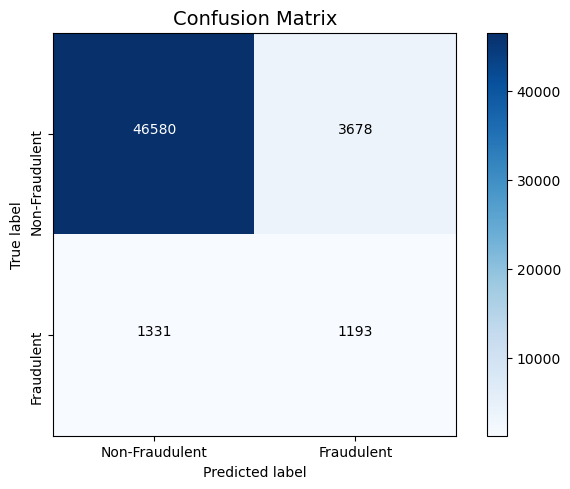

In [81]:
# optimised model for our score
dt_opt = DecisionTreeClassifier(random_state = 0, class_weight={1:10, 0:1}, max_depth= 5, min_samples_leaf=100)
dt_opt.fit(X_train,y_train)
y_pred_dt = dt_opt.predict(X_test)
cm_dt_opt = confusion_matrix(y_test, y_pred_dt)
plot_confusion_matrix(cm_dt_opt)

In [82]:
print("Precision score is ", precision_score(y_test, y_pred_dt))
print("Recall score is ", recall_score(y_test, y_pred_dt))
print("f1 score is", f1_score(y_test, y_pred_dt))

Precision score is  0.2449189078218025
Recall score is  0.472662440570523
f1 score is 0.3226504394861393


In [83]:
print("Our score is", our_score(dt_opt, X_test, y_test))

Our score is 0.5423405840936008


In [85]:
print("The initial loss was equal to", retrieved_money(dt_opt, X_test, y_test)[0], "dollars, \nwe retrieved", retrieved_money(dt_opt, X_test, y_test)[1], "dollars and the maximum amount that was retrievable is", retrieved_money(dt_opt, X_test, y_test)[2], "dollars.")

The initial loss was equal to -280734.98 dollars, 
we retrieved 134886.53000000003 dollars and the maximum amount that was retrievable is 248711.85000000003 dollars.


## Random Forest

In [86]:
# GridSearch
param = {
    "class_weight" : [{1:i, 0:1} for i in [1, 10, 15, 20]],
    "min_samples_leaf" : [1, 5, 10, 25, 50, 100, 200],
    "max_depth" : [1, 5, 10, 15, 20, 25, 30],
    "n_estimators" : [10, 50, 100, 200, 300]
 }

model2 = RandomForestClassifier(random_state = 0, n_jobs = -1)
CV_model2 = GridSearchCV(estimator=model2, cv = kf, n_jobs = -1, param_grid = param, scoring = our_score,verbose=10)
CV_model2.fit(X_train, y_train)

Fitting 10 folds for each of 980 candidates, totalling 9800 fits
[CV 1/10; 1/980] START class_weight={1: 1, 0: 1}, max_depth=1, min_samples_leaf=1, n_estimators=10
[CV 2/10; 1/980] START class_weight={1: 1, 0: 1}, max_depth=1, min_samples_leaf=1, n_estimators=10
[CV 3/10; 1/980] START class_weight={1: 1, 0: 1}, max_depth=1, min_samples_leaf=1, n_estimators=10
[CV 4/10; 1/980] START class_weight={1: 1, 0: 1}, max_depth=1, min_samples_leaf=1, n_estimators=10
[CV 5/10; 1/980] START class_weight={1: 1, 0: 1}, max_depth=1, min_samples_leaf=1, n_estimators=10
[CV 6/10; 1/980] START class_weight={1: 1, 0: 1}, max_depth=1, min_samples_leaf=1, n_estimators=10
[CV 7/10; 1/980] START class_weight={1: 1, 0: 1}, max_depth=1, min_samples_leaf=1, n_estimators=10
[CV 1/10; 1/980] END class_weight={1: 1, 0: 1}, max_depth=1, min_samples_leaf=1, n_estimators=10;, score=0.000 total time=   0.4s
[CV 8/10; 1/980] START class_weight={1: 1, 0: 1}, max_depth=1, min_samples_leaf=1, n_estimators=10
[CV 2/10; 1/9

/opt/mamba/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 5/10; 2/980] END class_weight={1: 1, 0: 1}, max_depth=1, min_samples_leaf=1, n_estimators=50;, score=0.000 total time=   2.8s
[CV 4/10; 4/980] START class_weight={1: 1, 0: 1}, max_depth=1, min_samples_leaf=1, n_estimators=200
[CV 3/10; 4/980] START class_weight={1: 1, 0: 1}, max_depth=1, min_samples_leaf=1, n_estimators=200
[CV 8/10; 2/980] END class_weight={1: 1, 0: 1}, max_depth=1, min_samples_leaf=1, n_estimators=50;, score=0.000 total time=   3.0s
[CV 5/10; 4/980] START class_weight={1: 1, 0: 1}, max_depth=1, min_samples_leaf=1, n_estimators=200
[CV 9/10; 2/980] END class_weight={1: 1, 0: 1}, max_depth=1, min_samples_leaf=1, n_estimators=50;, score=0.000 total time=   2.9s
[CV 6/10; 4/980] START class_weight={1: 1, 0: 1}, max_depth=1, min_samples_leaf=1, n_estimators=200
[CV 10/10; 2/980] END class_weight={1: 1, 0: 1}, max_depth=1, min_samples_leaf=1, n_estimators=50;, score=0.000 total time=   3.1s
[CV 7/10; 4/980] START class_weight={1: 1, 0: 1}, max_depth=1, min_samples_leaf

In [ ]:
print(CV_model2.best_params_)

{'class_weight': {1: 15, 0: 1}, 'max_depth': 20, 'min_samples_leaf': 25, 'n_estimators': 300}


In [ ]:
print(CV_model2.best_score_)

0.6816305193385761


### Results on test set

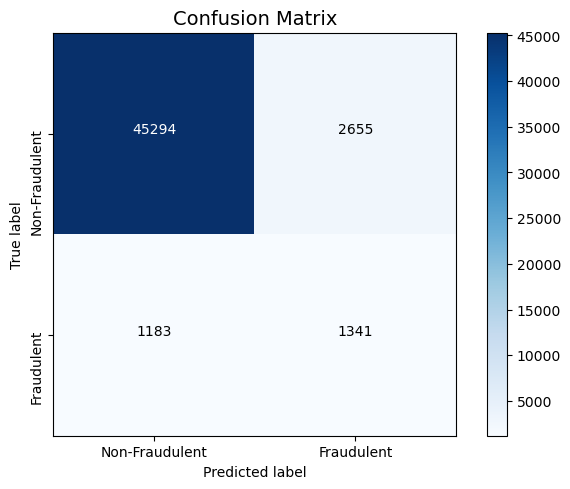

In [287]:
rf_opt = RandomForestClassifier(random_state = 0, class_weight= {1: 15, 0: 1}, max_depth= 20, min_samples_leaf= 25, n_estimators= 300, n_jobs = -1)
rf_opt.fit(X_train,y_train)
y_pred_rf = rf_opt.predict(X_test)
cm_rf_opt = confusion_matrix(y_test, y_pred_rf)
plot_confusion_matrix(cm_rf_opt)

In [295]:
print("Our score is equal to", our_score(rf_opt, X_test, y_test))

Our score is equal to 0.6841373985725664


In [300]:
print("The initial loss was equal to", retrieved_money(rf_opt, X_test, y_test)[0], "dollars, \nwe retrieved", retrieved_money(rf_opt, X_test, y_test)[1], "dollars and the maximum amount that was retrievable is", retrieved_money(rf_opt, X_test, y_test)[2], "dollars.")

The initial loss was equal to -293332.17 dollars, 
we retrieved 178781.19999999998 dollars and the maximum amount that was retrievable is 261323.52999999997 dollars.


In [304]:
print("Precision score is ", precision_score(y_test, y_pred_rf))
print("Recall score is ", recall_score(y_test, y_pred_rf))
print("f1 score is", f1_score(y_test, y_pred_rf))

Precision score is  0.3355855855855856
Recall score is  0.5312995245641838
f1 score is 0.41134969325153375
